In [1]:
import math
import random
from functools import lru_cache
from pathlib import Path
import matplotlib.pyplot as plt

import cv2
import numpy as np
from tqdm import tqdm


# Tracking Demo Sequence

In [2]:
image_top_down = cv2.imread("../assets/images/Camera_TopDown_ImageRGB_blank.png")
# set this to a path containing the fully rendered MOT dataset like "complex-logistics-yard-truck-scene_MOT_wo_Duplicates/mot_dataset"
MOT_DATASET_PATH = Path("/home/tom/Downloads/complex-logistics-yard-truck-scene_MOT_wo_Duplicates/mot_dataset")

CAMERA_NAMES = [
    "Camera_Entrance_Right",
    "Camera_Gates_Right",
    "Camera_Building_Right",
]

# ensure that each camera is present in the MOT dataset
assert all([camera_name in [x.name for x in MOT_DATASET_PATH.iterdir()] for camera_name in CAMERA_NAMES])

In [3]:
# parse all MOT files of the cameras
mot_files = {}

for camera_name in CAMERA_NAMES + ["Camera_TopDown"]:
    mot_files[camera_name] = {}
    with open(MOT_DATASET_PATH / camera_name / "gt/gt.txt") as f:
        for line in f.readlines():
            line = line.strip()
            if line == "":
                continue
            line = line.split(",")
            frame = int(line[0])
            id = int(line[1])
            x = float(line[2])
            y = float(line[3])
            w = float(line[4])
            h = float(line[5])
            mot_files[camera_name][frame] = mot_files[camera_name].get(frame, []) + [(id, x, y, w, h)]

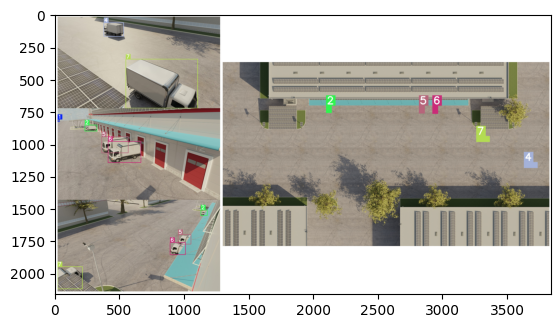

In [9]:
@lru_cache
def name_to_color(name: str) -> tuple[int, int, int]:
    """Convert a string to a random deterministic color.

    Uses a new random object instance to avoid messing with the global random state.

    Args:
        name (str): The string to convert

    Returns:
        Tuple[int, int, int]: A tuple of three integers representing the RGB color values (0-255)
    """
    rnd = random.Random(name)
    return (rnd.randint(0, 255), rnd.randint(0, 255), rnd.randint(0, 255))


def plot_frame(frame_number: int, padding: int = 20, plot_text: bool = False):
    # load the correct image for each camera
    image_paths = [MOT_DATASET_PATH / camera_name / f"img1/{frame_number:06d}.jpg" for camera_name in CAMERA_NAMES]
    assert all([image_path.exists() for image_path in image_paths]), f"not all images exist: {image_paths}"
    camera_images = [cv2.imread(str(image_path)) for image_path in image_paths]

    # draw the bounding boxes of all objects in the frame
    # put the id of the object as text above the bounding box with colored background
    for idx, camera_name in enumerate(CAMERA_NAMES):
        if frame_number not in mot_files[camera_name]:
            continue
        for id, x, y, w, h in mot_files[camera_name][frame_number]:
            color = name_to_color(f"Truck_{id}")
            camera_images[idx] = cv2.rectangle(camera_images[idx], (int(x), int(y)), (int(x+w), int(y+h)), color, 5)
            camera_images[idx] = cv2.rectangle(camera_images[idx], (int(x), int(y-60)), (int(x+55), int(y)), color, -1)
            camera_images[idx] = cv2.putText(camera_images[idx], str(id), (int(x+5), int(y-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 5)


    # stack all camera images on top of each other
    camera_images_stacked = cv2.vconcat(camera_images)

    # a new cv2 image to draw on in 4k resolution
    image = np.full((2160, 3840, 3), 255, dtype=np.uint8)    

    # Desired height
    desired_height = image.shape[0] - padding*2

    # Calculate the ratio of the new height to the old height
    ratio = desired_height / camera_images_stacked.shape[0]

    # Calculate the new width to maintain the aspect ratio
    new_width = int(camera_images_stacked.shape[1] * ratio)

    # Resize the image using numpy
    resized_image = cv2.resize(camera_images_stacked, (new_width, desired_height))

    # paste the resized image into the final image
    image[padding:-padding, padding:new_width+padding, :] = resized_image

    # draw the bounding boxes of all trucks in the top down image
    image_top_down_frame = image_top_down.copy()
    if frame_number in mot_files["Camera_TopDown"]:
        for id, x, y, w, h in mot_files["Camera_TopDown"][frame_number]:
            color = name_to_color(f"Truck_{id}")
            image_top_down_frame = cv2.rectangle(image_top_down_frame, (int(x), int(y)), (int(x+w), int(y+h)), color, cv2.FILLED)
            image_top_down_frame = cv2.rectangle(image_top_down_frame, (int(x), int(y-60)), (int(x+55), int(y)), color, -1)
            image_top_down_frame = cv2.putText(image_top_down_frame, str(id), (int(x+5), int(y-10)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 5)

    # draw the top down image on the right side of the final image, centered vertically
    desired_width = image.shape[1] - new_width - 3*padding
    new_height = int(image_top_down_frame.shape[0] * (desired_width / image_top_down_frame.shape[1]))
    image_top_down_frame_resized = cv2.resize(image_top_down_frame, (desired_width, new_height))

    center_y = image.shape[0] // 2
    start_y = center_y - math.floor(new_height / 2)
    end_y = center_y + math.ceil(new_height / 2)
    image[start_y:end_y, new_width+2*padding:-padding, :] = image_top_down_frame_resized

    if plot_text:
        # put the text "Operator View" above the operator view image
        image = cv2.putText(image, "Live computed operator view", (new_width+2*padding, start_y-40), cv2.FONT_HERSHEY_SIMPLEX, 4, (40,)*3, 10)

        # put the text "Yard Lense on Edge" in the bottom right corner
        text = "Yard Lense on Edge"
        (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 2, 6)
        text_x = image.shape[1] - text_width - padding
        text_y = image.shape[0] - padding
        image = cv2.putText(image, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (40,)*3, 6)
    
    # save the final image
    file_path = Path(f"tracking_demo/frame_{frame_number:06d}.jpg")
    file_path.parent.mkdir(exist_ok=True)
    file_path = str(file_path)
    cv2.imwrite(file_path, image) 
    return file_path

file_path = plot_frame(563)

plt.imshow(cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB))
plt.show()

In [61]:
first_frame = 500
last_frame = 1100

for frame_number in tqdm(range(first_frame, last_frame)):
    plot_frame(frame_number)

100%|██████████| 600/600 [02:26<00:00,  4.09it/s]


Now run this command: `ffmpeg -framerate 30 -pattern_type glob -i 'tracking_demo/frame_*.jpg' -c:v libx264 -pix_fmt yuv420p tracking_demo_sequence.mp4`